# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import glob
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [2]:
region = "south_america"
input_gisaid_files = glob.glob(f'h3n2/data/raw/roi/*{region}*.xls')

#### Outputs



In [3]:
export_augur = 'h3n2/data/clean/south_america_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
# Read each file into a dataframe
dfs = [pd.read_excel(file) for file in input_gisaid_files]

# Join all dataframes into one
meta_raw = pd.concat(dfs, ignore_index=True)
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_319713,EPI1266226|3000685478_N8K8YF6W_v1_1,EPI1266227|3000685478_N8K8YF6W_v1_2,EPI1266225|3000685478_N8K8YF6W_v1_3,EPI1266229|3000685478_N8K8YF6W_v1_4,EPI1266222|3000685478_N8K8YF6W_v1_5,EPI1266228|3000685478_N8K8YF6W_v1_6,EPI1266224|3000685478_N8K8YF6W_v1_7,EPI1266223|3000685478_N8K8YF6W_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_319732,EPI1266378|3000685740_N8K8YG7A_v1_1,EPI1266379|3000685740_N8K8YG7A_v1_2,EPI1266377|3000685740_N8K8YG7A_v1_3,EPI1266381|3000685740_N8K8YG7A_v1_4,EPI1266374|3000685740_N8K8YG7A_v1_5,EPI1266380|3000685740_N8K8YG7A_v1_6,EPI1266376|3000685740_N8K8YG7A_v1_7,EPI1266375|3000685740_N8K8YG7A_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_320270,EPI1268532|3000685741_N8K8YG7F_v1_1,NaN,EPI1268531|3000685741_N8K8YG7F_v1_3,EPI1268533|3000685741_N8K8YG7F_v1_4,EPI1268528|3000685741_N8K8YG7F_v1_5,NaN,EPI1268530|3000685741_N8K8YG7F_v1_7,EPI1268529|3000685741_N8K8YG7F_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_320271,NaN,EPI1268535|3000685731_N8K8YG61_v1_2,NaN,EPI1268536|3000685731_N8K8YG61_v1_4,EPI1268534|3000685731_N8K8YG61_v1_5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_345593,NaN,NaN,NaN,EPI1384633|938-18,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [8]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Brazil/6356/2018,2018-06-11,EPI_ISL_319713,South America / Brazil,Human,Centers for Disease Control and Prevention,Instituto Adolfo Lutz,h3n2_flu
1,A/Argentina/70/2018,2018-06-14,EPI_ISL_319732,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu
2,A/Argentina/71/2018,2018-06-18,EPI_ISL_320270,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu
3,A/Argentina/56/2018,2018-06-07,EPI_ISL_320271,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu
4,A/Minas Gerais/938/2018,2018-07-13,EPI_ISL_345593,South America / Brazil / MARIA DA FE,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,FUNED MG,h3n2_flu
5,A/Minas Gerais/941/2018,2018-07-06,EPI_ISL_345594,South America / Brazil / BELO HORIZONTE,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,FUNED MG,h3n2_flu
6,A/Bahia/952/2018,2018-07-10,EPI_ISL_345595,South America / Brazil / FEIRA DE SANTANA,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central de Saúde Pública Professor...,h3n2_flu
7,A/Santa Catarina/1200/2018,2018-09-02,EPI_ISL_345597,South America / Brazil / ITAJAI,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,LACEN SC,h3n2_flu
8,A/Parana/1256/2018,2018-09-03,EPI_ISL_345598,South America / Brazil / FOZ DO IGUACU,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central do Estado do Paraná - LACE...,h3n2_flu
9,A/Parana/1257/2018,2018-09-02,EPI_ISL_345599,South America / Brazil / SIQUEIRA CAMPOS,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central do Estado do Paraná - LACE...,h3n2_flu


## Parse metadata

### Parse country

In [9]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [10]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Brazil/6356/2018,2018-06-11,EPI_ISL_319713,South America / Brazil,Human,Centers for Disease Control and Prevention,Instituto Adolfo Lutz,h3n2_flu,South America,Brazil
1,A/Argentina/70/2018,2018-06-14,EPI_ISL_319732,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu,South America,Argentina
2,A/Argentina/71/2018,2018-06-18,EPI_ISL_320270,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu,South America,Argentina
3,A/Argentina/56/2018,2018-06-07,EPI_ISL_320271,South America / Argentina,Human,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,h3n2_flu,South America,Argentina
4,A/Minas Gerais/938/2018,2018-07-13,EPI_ISL_345593,South America / Brazil / MARIA DA FE,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,FUNED MG,h3n2_flu,South America,Brazil
5,A/Minas Gerais/941/2018,2018-07-06,EPI_ISL_345594,South America / Brazil / BELO HORIZONTE,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,FUNED MG,h3n2_flu,South America,Brazil
6,A/Bahia/952/2018,2018-07-10,EPI_ISL_345595,South America / Brazil / FEIRA DE SANTANA,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central de Saúde Pública Professor...,h3n2_flu,South America,Brazil
7,A/Santa Catarina/1200/2018,2018-09-02,EPI_ISL_345597,South America / Brazil / ITAJAI,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,LACEN SC,h3n2_flu,South America,Brazil
8,A/Parana/1256/2018,2018-09-03,EPI_ISL_345598,South America / Brazil / FOZ DO IGUACU,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central do Estado do Paraná - LACE...,h3n2_flu,South America,Brazil
9,A/Parana/1257/2018,2018-09-02,EPI_ISL_345599,South America / Brazil / SIQUEIRA CAMPOS,Human,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,Laboratório Central do Estado do Paraná - LACE...,h3n2_flu,South America,Brazil


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [11]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [12]:
meta_working.head(n=10)['strain']

0            A/Brazil/6356/2018
1           A/Argentina/70/2018
2           A/Argentina/71/2018
3           A/Argentina/56/2018
4       A/Minas_Gerais/938/2018
5       A/Minas_Gerais/941/2018
6              A/Bahia/952/2018
7    A/Santa_Catarina/1200/2018
8            A/Parana/1256/2018
9            A/Parana/1257/2018
Name: strain, dtype: object

### Deduplicate strains

In [13]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 5257 records.
	There were 4989 unique records.
	After cleaning, there were 4989 records remaining.


### Clean up countries

In [14]:
meta_working['country'].value_counts(dropna=False)

country
Brazil                               2748
Chile                                1251
Peru                                  286
Argentina                             228
Bolivia                               110
Colombia                               97
Ecuador                                93
French Guiana                          47
Uruguay                                43
Paraguay                               31
Suriname                               27
Guyana                                 13
Venezuela, Bolivarian Republic of       8
None                                    7
Name: count, dtype: int64

In [15]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {'Venezuela, Bolivarian Republic of': 'Venezuela'}
    ))

In [16]:
meta_working['country'].value_counts(dropna=False)

country
Brazil           2748
Chile            1251
Peru              286
Argentina         228
Bolivia           110
Colombia           97
Ecuador            93
French Guiana      47
Uruguay            43
Paraguay           31
Suriname           27
Guyana             13
Venezuela           8
None                7
Name: count, dtype: int64

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [17]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False)

## Plot and list all strains by country

### Plot strain counts by country

In [18]:
meta_clean['strain'].count()

4989

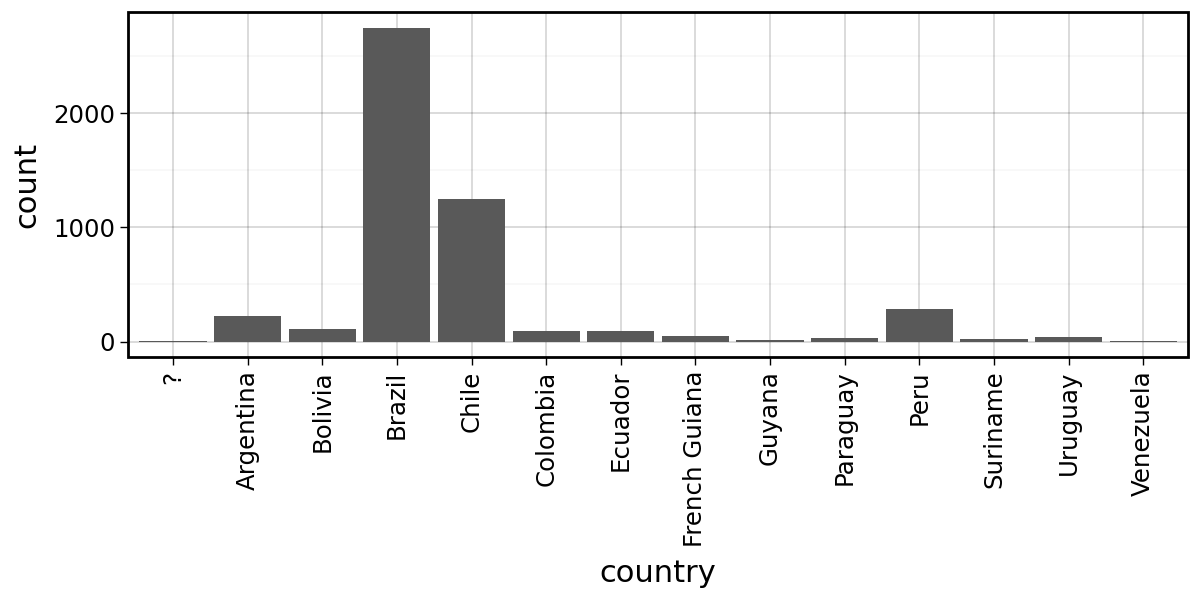

In [19]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


In [20]:
meta_clean['year_month'] = meta_clean['date'].str[:7]
meta_clean.head()

,strain,date,virus,region,country,host,isolate_id,submitting_lab,originating_lab,year_month
0,A/Brazil/6356/2018,2018-06-11,h3n2_flu,South America,Brazil,Human,EPI_ISL_319713,Centers for Disease Control and Prevention,Instituto Adolfo Lutz,2018-06
1,A/Argentina/70/2018,2018-06-14,h3n2_flu,South America,Argentina,Human,EPI_ISL_319732,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,2018-06
2,A/Argentina/71/2018,2018-06-18,h3n2_flu,South America,Argentina,Human,EPI_ISL_320270,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,2018-06
3,A/Argentina/56/2018,2018-06-07,h3n2_flu,South America,Argentina,Human,EPI_ISL_320271,Centers for Disease Control and Prevention,Instituto Nacional de Enfermedades Infecciosas,2018-06
4,A/Minas_Gerais/938/2018,2018-07-13,h3n2_flu,South America,Brazil,Human,EPI_ISL_345593,Instituto Oswaldo Cruz FIOCRUZ - Laboratory of...,FUNED MG,2018-07


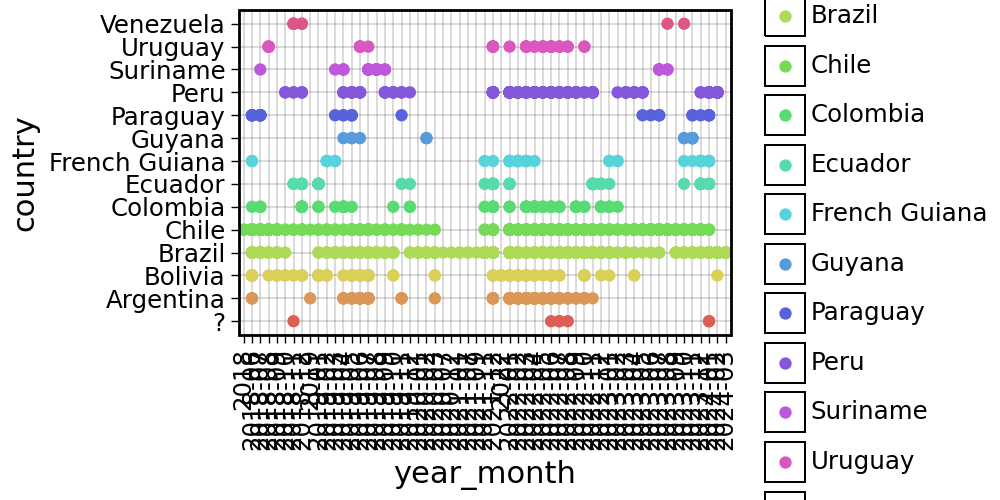

In [21]:
coverage = (
    p9.ggplot(meta_clean, p9.aes(x='year_month',
                                 y='country',
                                 color='country'))
    + p9.geom_point()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(5,
                            2.5))
)

coverage

### List strains by country

In [22]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Argentina (n=228)
A/Argentina/70/2018
A/Argentina/71/2018
A/Argentina/56/2018
A/Argentina/2852/2019
A/Argentina/2840/2019
A/Argentina/2819/2019
A/Argentina/3092/2022
A/Argentina/2760/2022
A/Argentina/2828/2022
A/Argentina/2812/2022
A/Argentina/3057/2022
A/Argentina/2937/2022
A/Argentina/2948/2022
A/Argentina/2809/2022
A/Argentina/2826/2022
A/Argentina/2798/2022
A/Argentina/2766/2022
A/Argentina/2800/2022
A/Argentina/2753/2022
A/Argentina/3041/2022
A/Argentina/2983/2022
A/Argentina/2972/2022
A/Argentina/2778/2022
A/Argentina/3030/2022
A/Argentina/2987/2022
A/Argentina/3052/2022
A/Argentina/3072/2022
A/Argentina/3012/2022
A/Argentina/2902/2022
A/Argentina/2954/2022
A/Argentina/3005/2022
A/Argentina/2814/2022
A/Argentina/2958/2022
A/Argentina/2741/2022
A/Argentina/2962/2022
A/Argentina/2761/2022
A/Argentina/2853/2022
A/Argentina/3084/2022
A/Argentina/4500/2022
A/Argentina/3104/2022
A/Argentina/3150/2022
A/Argentina/1333/2019
A/Argentina/1356/2019
A/Argentina/840/2019
A/Argentina/932/2019
